In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [4]:
df = pd.read_csv('year_per_patient_num.csv')
df['timeslice'] = 1
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df.head()

,age,gender,project_patient_id,marital_relationship,marital_single,marital_unknown,race_black,race_other,race_unknown,race_white,...,count_anti_il12,count_anti_integrin,count_anti_tnf,count_immunomodulators,count_systemic_steroids,count_vitamin_d,proc_count,is_hospitalization,is_er_visit,timeslice
0,70,1,3fa42a37-41a5-4995-8085-cc9bf1b259e4,0,0,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,2,2,4,1
1,60,0,70c8c891-183c-4355-bde7-350434fb6e4a,0,0,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,1,1
2,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2,1
3,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1,1
4,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,3.0,1.0,3,3,3,1


In [5]:
df.shape

(2083, 42)

In [6]:
# Unique patients
len(df['project_patient_id'].unique())

1185

In [7]:
# Create a sequence number representing individual timeslices for each patient
for p_id in df['project_patient_id'].unique():
    temp = df.query('project_patient_id == "' + p_id + '"').sort_values('encounter_year')
    cnt = 1
    for idx, row in temp.iterrows():
        df.at[idx, 'timeslice'] = cnt
        cnt+=1

In [8]:
df.head()

,age,gender,project_patient_id,marital_relationship,marital_single,marital_unknown,race_black,race_other,race_unknown,race_white,...,count_anti_il12,count_anti_integrin,count_anti_tnf,count_immunomodulators,count_systemic_steroids,count_vitamin_d,proc_count,is_hospitalization,is_er_visit,timeslice
0,70,1,3fa42a37-41a5-4995-8085-cc9bf1b259e4,0,0,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,2,2,4,1
1,60,0,70c8c891-183c-4355-bde7-350434fb6e4a,0,0,1,0,0,1,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,1,1
2,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,3,1,2,1
3,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,1.0,0.0,1,0,1,2
4,69,0,a9c3cee8-9f41-47cb-8f0d-af62ef0f31f9,1,0,0,0,0,0,1,...,0.0,0.0,0.0,1.0,3.0,1.0,3,3,3,3


In [9]:
def train_predict_with_model(model, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    return score

In [10]:
def train_predict_ann(X, y):
    model = Sequential()
    model.add(Dense(12, input_dim=len(X.columns), activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X, y, epochs=10, batch_size=10)
    return model.evaluate(X, y)


In [11]:
def eval_models(start_timeslice, predictors, response, key, show_rankings = False, train_ann = False):
    X = df.sort_values(key).query('timeslice == ' + str(start_timeslice))[
        predictors
    ]

    y = df.sort_values(key).query('timeslice == ' + str((start_timeslice + 1)))[response]
    
    match_df = pd.merge(X, y, how='inner', left_on=key, right_on=key)
    
    
    X = match_df[predictors].drop([key], axis=1)
    y = match_df[response].drop([key], axis=1).iloc[:, 0]
    #y2 = match_df['target_er_visits']
    
    
    models = {
        "kNN" : KNeighborsRegressor(n_neighbors=3), 
        "SVM" : svm.SVR(),
        "RF" : RandomForestRegressor(random_state=1, max_depth=10)
    }
        
    print("Starting timeslice: ", start_timeslice)
    print("Patients used in training models: ", match_df.shape[0])
    for key, model in models.items():
        
        
        
        score = train_predict_with_model(model, X, y)
        print("\t" + key + ": ", score)
        print("\t--------------------")
        
        if key == "RF" and show_rankings:
            features = X.columns
            importances = model.feature_importances_
            indices = np.argsort(importances)[-10:]  # top features
            plt.title('Feature Importances')
            plt.barh(range(len(indices)), importances[indices], color='b', align='center')
            plt.yticks(range(len(indices)), [features[i] for i in indices])
            plt.xlabel('Relative Importance')
            plt.show()
            
            rfe = RFE(model, 10)
            fit = rfe.fit(X, y)
            #print("Num Features:",  fit.n_features_)
            #print("Selected Features: ", fit.support_)
            #print("Feature Ranking: ",  fit.ranking_)
            features = str(fit.ranking_).replace('\n', '').replace('[', '').replace(']', '').replace('  ', ' ').split(' ')[1:]
            #print(features)
            for i in range(0, len(features)):
                if int(features[i]) == 1:
                    print(X.columns[i])
    if train_ann:        
        ann = train_predict_ann(X, y)
        print("ANN: ", ann)
        
    print("_________________________________________________")

In [12]:
df.columns

Index(['age', 'gender', 'project_patient_id', 'marital_relationship',
       'marital_single', 'marital_unknown', 'race_black', 'race_other',
       'race_unknown', 'race_white', 'empl_employed', 'empl_student',
       'empl_unemployed', 'empl_unknown', 'encounter_year', 'office_visit',
       'telephone', 'max_albumin', 'max_crp', 'max_eos', 'max_esr',
       'max_hemoglobin', 'max_monocytes', 'max_vitamin_d', 'min_albumin',
       'min_crp', 'min_eos', 'min_esr', 'min_hemoglobin', 'min_monocytes',
       'min_vitamin_d', 'count_5_asa', 'count_anti_il12',
       'count_anti_integrin', 'count_anti_tnf', 'count_immunomodulators',
       'count_systemic_steroids', 'count_vitamin_d', 'proc_count',
       'is_hospitalization', 'is_er_visit', 'timeslice'],
      dtype='object')

In [15]:
'''
predictors = ['age', 'gender', 'project_patient_id',
       'marital_relationship', 'marital_single', 'marital_unknown',
       'race_black', 'race_other', 'race_unknown', 'race_white',
       'empl_employed', 'empl_student', 'empl_unemployed', 'empl_unknown',
       'encounter_year', 'office_visit', 'telephone', 'max_albumin', 'max_crp',
       'max_eos', 'max_esr', 'max_hemoglobin', 'max_monocytes',
       'max_vitamin_d', 'min_albumin', 'min_crp', 'min_eos', 'min_esr',
       'min_hemoglobin', 'min_monocytes', 'min_vitamin_d', 'count_5_asa',
       'count_anti_il12', 'count_anti_integrin', 'count_anti_tnf',
       'count_immunomodulators', 'count_systemic_steroids', 'count_vitamin_d',
       'proc_count']
'''

predictors = ['age', 'gender', 'project_patient_id',
       'marital_relationship', 'marital_single', 'marital_unknown',
       'race_black', 'race_other', 'race_unknown', 'race_white',
       'empl_employed', 'empl_student', 'empl_unemployed', 'empl_unknown',
       'encounter_year', 'office_visit', 'telephone', 'max_albumin', 'max_crp',
       'max_eos', 'max_esr', 'max_hemoglobin', 'max_monocytes',
       'max_vitamin_d', 'min_albumin', 'min_crp', 'min_eos', 'min_esr',
       'min_hemoglobin', 'min_monocytes', 'min_vitamin_d', 
              'count_systemic_steroids', 'proc_count']

response = ['project_patient_id','is_hospitalization'] #'target_er_visits'
key = 'project_patient_id'

Starting timeslice:  1
Patients used in training models:  457
	kNN:  -0.34287170347114904
	--------------------
	SVM:  -0.12568100075605204
	--------------------
	RF:  -0.10442348020957604
	--------------------


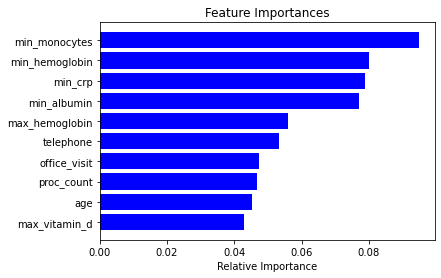

/Users/dmitriyb/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=10 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


telephone
max_albumin
max_eos
max_esr
max_hemoglobin
min_albumin
min_crp
min_hemoglobin
min_monocytes
proc_count
_________________________________________________


In [16]:
for i in range(1, 2):
    eval_models(i, predictors, response, key, True, False)

In [ ]:
predictors = ['project_patient_id','contact_encounter_frequency', 'office_encounter_frequency',
       'psych_comorbidity','med_antibiotics', 'gender', 'race',
       'age_le', 'employment_status_le']

response = ['project_patient_id','target_hospitalizations'] #'target_er_visits'
key = 'project_patient_id'

In [ ]:
for i in range(1, 6):
    eval_models(i, predictors, response, key, True, False)